# Covid-19 Dashboard
---

Analysis of Covid-19 cases based on data reported on the European CDC website. The data is updated once daily and can differ from other sources because the reporting times for each country is different. E.g. the UK figures are a day late

---

Chandranath Gunjal, 2020

### Code

In [1]:
import requests
import numpy as np
import pandas as pd

import IPython.display as ipd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(style='whitegrid', context='notebook', palette='muted')

pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 10)

In [2]:
# Fetch file

def fetch_ECDC_file(asof):
    """Fetch file from ECDC website. Returns requests.response"""    
    site = 'https://www.ecdc.europa.eu/sites/default/files/documents/'
    url1 = site + 'COVID-19-geographic-disbtribution-worldwide-' + asof + '.xlsx'
    url2 = site + 'COVID-19-geographic-disbtribution-worldwide-' + asof + '.xls'
    
    # format can be .xlsx or .xls - try both
    r = requests.get(url1, allow_redirects=True)
    if r.ok:
        return r

    r = requests.get(url2, allow_redirects=True)
    return r


def load_data(asof, local_csv):
    """Read local csv or fetch from ECDC website"""
    try:
        # read local
        df = pd.read_csv(local_csv, parse_dates=[0], na_filter=False, index_col=False)

    except:
        # fetch data
        response = fetch_ECDC_file(asof)
        if not response.ok:
            response.raise_for_status()

        # load into data frame using the response
        df = cleanse_ECDC_data(pd.read_excel(response.content, parse_dates=True, na_filter=False))

        # save locally
        df.to_csv(local_csv, index=False)
    return df


In [3]:
# Clean and generate stats

def lookup_country(df, x):
    """Lookup a country name or geoid. Empty string prints full list"""
    x, n = x.upper(), len(x)
    all_names = dict(sorted(zip(df['geoid'], df['country'])))

    # simple search - either matches geoid or beginning of country name
    subset = {g:c for g,c in all_names.items() if x == g or x == c.upper()[:n]}
    
    # display
    for i, (g,c) in enumerate(subset.items(), 1):
        print('{: <26}'.format((g + ': ' + c)[:24]), end='')
        if i % 3 == 0: print()
    print()
    return


def compute_global_totals(df, label, geoid):
    """Return dataframe with world-wide statistics"""
    if (df['geoid'] == geoid).any() or (df['country'] == label).any():
        raise ValueError('duplicate error: world stats already exist in dataframe'.format())
   
    gbl = df.groupby(['date'], as_index=False).sum()
    gbl['country'] = label
    gbl['geoid'] = geoid
    return gbl


def cleanse_ECDC_data(df):
    """Cleanse and reformat ECDC data"""
    # rename columns
    rv = {'daterep': 'date', 'countries and territories': 'country'}
    c = [rv[k] if k in rv else k for k in (i.lower() for i in df.columns)]
    df.columns = c   

    needed_cols = ['date', 'country', 'geoid', 'cases', 'deaths']
    ndf = pd.DataFrame(df, columns=needed_cols)
    
    # sort by country and date
    ndf.sort_values(by=['geoid', 'date'], ascending=[True, True],
                    axis=0, inplace=True, ignore_index=True)
    
    # append global totals
    ndf = ndf.append(compute_global_totals(ndf, 'World', 'WW'), ignore_index=True)

    # append cumulative counts
    ndf['cum_cases'] = ndf.groupby(['geoid'])['cases'].cumsum()
    ndf['cum_deaths'] = ndf.groupby(['geoid'])['deaths'].cumsum()
    return ndf


def compute_fatality_ratio(df, lag, new_col):
    """Compute fatality ratio with a given lag. Creates a new column in given df"""                    
    def shifted_fr(x):
        x[new_col] = (x['cum_deaths'] / x['cum_cases'].shift(lag) * 100.0).fillna(0).round(2)
        return x
        
    df[new_col] = df.groupby(['geoid']).apply(shifted_fr)[new_col]
    return


def compute_timeline(df, threshold, col, new_col):
    """Count days from when a variable crossed a given threshold. Creates a new column in df"""
    df[new_col] = 0
    df.loc[df[col] >= threshold, new_col] = 1
    df[new_col] = df.groupby(['geoid'])[new_col].cumsum()
    return


def compute_growth_rate(df, lag, col, new_col, dbl_col):
    """Compute average growth rate of a variable. Creates new columns in df"""
    def growth_rate(x):
        x[new_col] = (x[col] / x[col].shift(lag)).fillna(0).replace(np.inf, 0).\
                        pow(1.0/lag).sub(1).clip(0).mul(100).round(2)
        return x
    
    df[new_col] = df.groupby(['geoid']).apply(growth_rate)[new_col]
    df[dbl_col] = (np.log(2) / np.log(df[new_col].div(100).add(1))).fillna(0).replace(np.inf, 0).round(2)
    return


def compute_stats(df, threshold=10, avg_period=5):
    """Run all computations"""
    # Create a timeline - first day when cum_cases exceeded a threshold
    compute_timeline(df, threshold, 'cum_cases', 'timeline')

    # compute fatality ratios - both unlagged and lagged
    compute_fatality_ratio(df, 0, 'fatality0')
    compute_fatality_ratio(df, 7, 'fatality7')

    # compute 5 day growth rates and doubling times
    compute_growth_rate(df, avg_period, 'cum_cases', 'gr_cases', 'dbl_cases')
    compute_growth_rate(df, avg_period, 'cum_deaths', 'gr_deaths', 'dbl_deaths')
    return df


In [4]:
# report & charts

nice_names = {'date': 'Date', 'country': 'Country', 'geoid': 'GeoId',
              'cases': 'Daily Cases', 'deaths': 'Daily Deaths',
              'cum_cases': 'Cum.Cases', 'cum_deaths': 'Cum.Deaths', 
              'timeline': 'Timeline',
              'fatality0': 'Fatality(spot)', 'fatality7': 'Fatality(7-day lagged)',
              'gr_cases': 'Growth Rate Cases', 'gr_deaths': 'Growth Rate Deaths'
             }


def spruce(df, addnl_cols=[], main_cols=[], show_nice_names=False):
    """Spruce up index & columns for displaying a dataframe"""
    # choose columns to show
    all_cols = main_cols + addnl_cols
    if len(all_cols) == 0: all_cols = df.columns
    
    y = pd.DataFrame(df, columns=all_cols)
 
    #
    y.index = np.arange(1, len(df) + 1)
    if show_nice_names: y.columns = [nice_names[c] for c in all_cols]
    return y


def rpt_show(df, caption, asof=None, sortby=None, count=0, show_nice_names=False):
    """Show part of a dataframe"""
    if count == 0: count = len(df)

    y = df
    if asof is not None: y = y[y.date == asof]
    if sortby is not None: y = y.sort_values([sortby], ascending=False)
    
    # show report 
    print('\n')
    print(caption)
    ipd.display(spruce(y.head(count), show_nice_names=show_nice_names))
    print('\n')
    return


def rpt_daily_stats(df, asof, variables, sort_ascending=False, count=10, show_nice_names=False):
    """Daily stats report"""
    main_cols = ['country']
    
    y = pd.concat(
            (spruce(df[df.date == asof].sort_values([v], ascending=sort_ascending).head(count),
                    [v], main_cols, show_nice_names=show_nice_names)
         for v in variables), axis=1)
    
    rpt_show(y, 'Daily statistics for ' + asof)
    return


In [5]:
# more reports & charts
def rpt_country(df_all, geoid, history=7):
    """Summary report for given country"""
    
    # show history
    df = df_all[(df_all.geoid == geoid) & (df_all.timeline > 0)]
    if len(df) < 1:
        print("Insufficient data for requested country")
        return
    rpt_show(df.tail(history)[::-1], '{} [{}]: Last {} days. Timeline: Day-{}'.\
             format(df['country'].iloc[0], geoid, history, df['timeline'].max()))
    
    # show charts
    plt.figure(1, figsize=(16, 15))
    ax = plt.subplot(321)
    df.plot(ax=ax, x='timeline', y=['cum_cases', 'gr_cases'], secondary_y='gr_cases')

    ax = plt.subplot(322)
    df.plot(ax=ax, x='timeline', y=['cum_deaths', 'gr_deaths'], secondary_y='gr_deaths')

    ax = plt.subplot(323)
    df.plot(ax=ax, x='timeline', y=['cases'])
    
    ax = plt.subplot(324)
    df.plot(ax=ax, x='timeline', y=['deaths'])
    
    ax = plt.subplot(325)
    df.plot(ax=ax, x='timeline', y=['fatality0', 'fatality7'])

    ax = plt.subplot(326)
    df.plot(ax=ax, x='timeline', y=['dbl_cases', 'dbl_deaths'])

    plt.show()
    return


def timeline_chart(df, geoid_list, col='cum_cases'):
    """Chart variable for all countries"""
    p = df[(df.geoid.isin(geoid_list)) & (df.timeline > 0)].pivot(index='timeline', columns='country', values=col)

    plt.figure(1, figsize=(16, 8))
    ax = plt.subplot(111)
    p.plot(ax=ax)
    
    plt.show()
    return

### Dashboard

Update asof to required date and load data

In [6]:
# general parameters
# ------------------

# asof date
asof = '2020-03-25'

# Day0 for each country is determined when cum_cases >= threshold
timeline_threshold = 10

# Period over which to compute the average growth rate
avg_period = 5

# Local filename - the cleaned data is saved here. If this file exists, the routine
# will load it instead of hitting the ECDC website
local_csv = 'ecdc_' + asof.replace('-', '') + '.csv'

# subsets of interest
home = 'UK'
world = 'WW'
monitor = ['WW', 'US', 'CN', 'IT', 'ES', 'DE', 'FR', 'CH', 'UK', 'IR', 'JP', 'IN', 'ZA', 'KR','RU']


# load and compute data
# ---------------------
df = compute_stats(load_data(asof, local_csv), timeline_threshold, avg_period)

# data subsets 
df_world = df[df['geoid'] == world]
df_home  = df[df['geoid'] == home]
df_mon   = df[df['geoid'].isin(monitor)]


In [7]:
# export computed dataframe if needed
#df.to_csv('cvdb_' + asof.replace('-', '') + '.csv')


### Description of column names
---
- _geoid:_ Geographic ID. WW has been included for World statistics
- _cases:_ Cases reported on the given date
- _cum_cases:_ Cumulative cases up to the given date


- _deaths:_ Deaths reported on the given date
- _cum_deaths:_ Cumulative deaths up to the given date
- _fatality0:_ Spot fatality ratio (%age) calculated as cum_deaths/cum_cases on the given date
- _fatality7:_ Lagged fatality ratio calculated as cum_deaths/cum_cases(7 days ago)


- _gr_cases:_ The growth rate (%age) in cases reported. This is a 5-day compounded moving average to smoothen the data
- _gr_deaths:_ The growth rate (%age) in deaths reported. Computed similar to gr_cases
- _dbl_cases:_ Days for cumulative cases reported to double in number. Implied from the growth rate; therefore lagging because of the averaging period used
- _dbl_deaths:_ Days for cumulative deaths reported to double in number


---

### Country Report

Show recent history and charts for a given country (or the world 'WW')

In [8]:
# find country - empty string prints full list
#lookup_country(df, 'fr')



United_Kingdom [UK]: Last 7 days. Timeline: Day-31


,date,country,geoid,cases,deaths,cum_cases,cum_deaths,timeline,fatality0,fatality7,gr_cases,dbl_cases,gr_deaths,dbl_deaths
1,2020-03-25,United_Kingdom,UK,1427,87,8077,422,31,5.22,21.64,19.77,3.84,23.99,3.22
2,2020-03-24,United_Kingdom,UK,967,54,6650,335,30,5.04,21.71,20.39,3.74,26.60,2.94
3,2020-03-23,United_Kingdom,UK,665,48,5683,281,29,4.94,20.20,23.85,3.24,36.18,2.24
4,2020-03-22,United_Kingdom,UK,1035,56,5018,233,28,4.64,20.44,26.60,2.94,33.47,2.40
5,2020-03-21,United_Kingdom,UK,706,33,3983,177,27,4.44,25.04,23.42,3.29,38.29,2.14
6,2020-03-20,United_Kingdom,UK,647,41,3277,144,26,4.39,24.41,23.51,3.28,46.97,1.80
7,2020-03-19,United_Kingdom,UK,680,43,2630,103,25,3.92,22.59,30.05,2.64,59.43,1.49


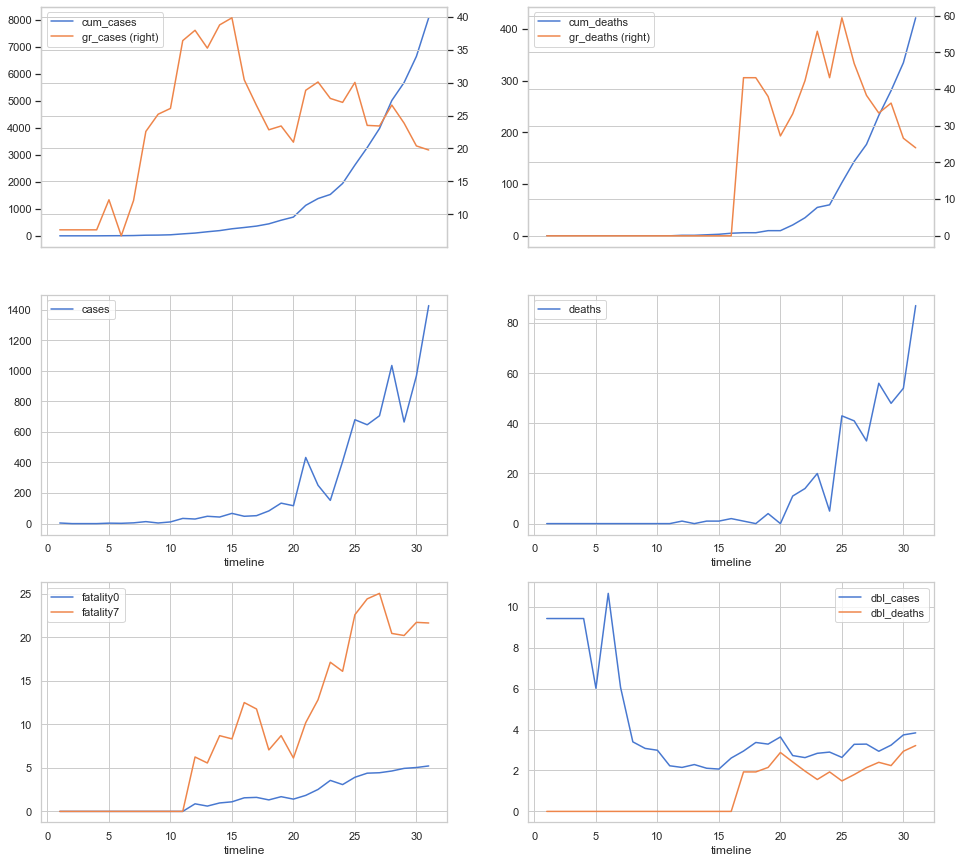

In [9]:
rpt_country(df, 'UK', history=7)

### Daily Rankings

Daily rankings by variable

In [10]:
rpt_daily_stats(df, asof, ['cum_cases', 'cum_deaths', 'cases', 'deaths'])



Daily statistics for 2020-03-25


,country,cum_cases,country,cum_deaths,country,cases,country,deaths
1,World,416916,World,18565,World,38876,World,2200
2,China,81847,Italy,6820,United_States_of_America,8789,Italy,743
3,Italy,69176,China,3287,Spain,6584,Spain,514
4,United_States_of_America,55231,Spain,2696,Italy,5249,France,240
5,Spain,39673,Iran,1934,France,2446,United_States_of_America,211
6,Germany,31554,France,1100,Germany,2342,Iran,122
7,Iran,24811,United_States_of_America,801,Iran,1762,United_Kingdom,87
8,France,22302,United_Kingdom,422,United_Kingdom,1427,Netherlands,63
9,South_Korea,9137,Netherlands,276,Netherlands,811,Belgium,34
10,Switzerland,8789,Germany,149,Austria,796,Germany,23


In [11]:
rpt_daily_stats(df, asof, ['fatality0', 'fatality7', 'gr_cases', 'gr_deaths'])



Daily statistics for 2020-03-25


,country,fatality0,country,fatality7,country,gr_cases,country,gr_deaths
1,Zimbabwe,50.00,Democratic_Republic_of_the_Congo,100.00,Guernsey,87.22,Portugal,61.54
2,Gambia,33.33,Gabon,100.00,Togo,78.26,Turkey,61.54
3,Cayman_Islands,33.33,Sudan,100.00,Dominican_Republic,71.55,Hungary,58.49
4,Cape_Verde,33.33,Gambia,100.00,Mauritius,69.52,Ecuador,55.18
5,Sudan,33.33,Dominican_Republic,54.55,El_Salvador,55.18,Brazil,50.29
6,Guyana,20.00,Bangladesh,50.00,Barbados,55.18,Malaysia,49.63
7,Gabon,16.67,Turkey,44.90,French_Polynesia,52.81,Panama,43.10
8,Niger,14.29,Nigeria,33.33,Cote_dIvoire,51.99,Belgium,42.18
9,San_Marino,11.23,Ghana,33.33,Suriname,51.57,United_States_of_America,39.80
10,Bangladesh,10.26,Indonesia,31.98,Kyrgyzstan,47.58,Denmark,39.77


### Monitor

Statistics for countries in the monitor list 

In [12]:
rpt_show(df_mon, 'Latest statistics by country', asof, 'cum_deaths')



Latest statistics by country


,date,country,geoid,cases,deaths,cum_cases,cum_deaths,timeline,fatality0,fatality7,gr_cases,dbl_cases,gr_deaths,dbl_deaths
1,2020-03-25,World,WW,38876,2200,416916,18565,86,4.45,9.52,11.45,6.39,13.44,5.50
2,2020-03-25,Italy,IT,5249,743,69176,6820,33,9.86,21.65,11.01,6.64,14.89,4.99
3,2020-03-25,China,CN,99,4,81847,3287,86,4.02,4.05,0.13,533.54,0.20,346.92
4,2020-03-25,Spain,ES,6584,514,39673,2696,28,6.80,24.12,18.27,4.13,28.58,2.76
5,2020-03-25,Iran,IR,1762,122,24811,1934,33,7.79,11.96,6.15,11.61,8.54,8.46
6,2020-03-25,France,FR,2446,240,22302,1100,47,4.93,14.23,15.19,4.90,24.21,3.20
7,2020-03-25,United_States_of_America,US,8789,211,55231,801,52,1.45,12.46,31.12,2.56,39.80,2.07
8,2020-03-25,United_Kingdom,UK,1427,87,8077,422,31,5.22,21.64,19.77,3.84,23.99,3.22
9,2020-03-25,Germany,DE,2342,23,31554,149,51,0.47,2.08,17.42,4.32,28.22,2.79
10,2020-03-25,South_Korea,KR,100,6,9137,126,54,1.38,1.50,1.10,63.36,4.73,15.00


### Timeline Charts

Plot variable against the timeline of each country

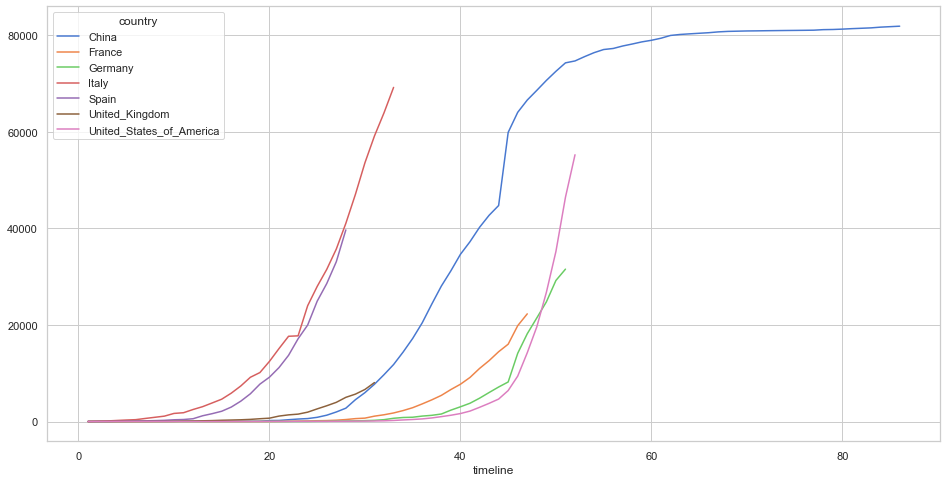

In [13]:
g_list = ['CN', 'UK', 'IT', 'ES', 'US', 'DE', 'FR']
timeline_chart(df, g_list, 'cum_cases')

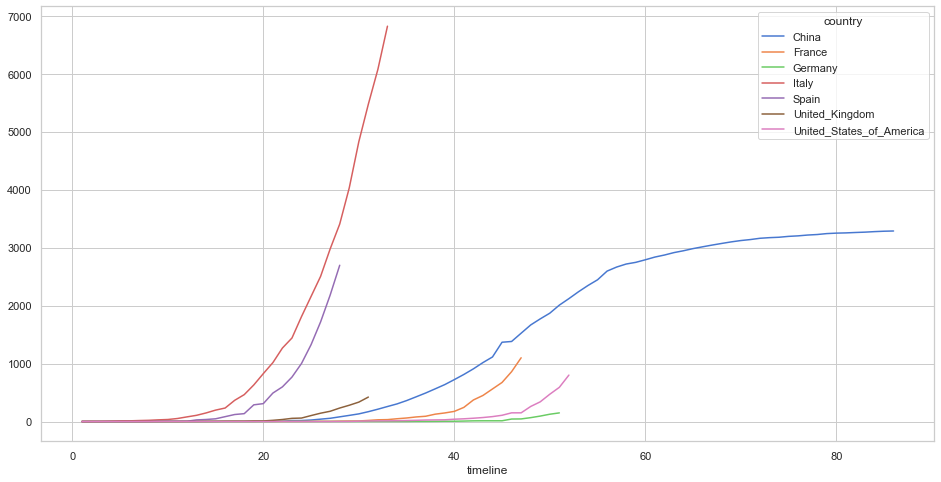

In [14]:
timeline_chart(df, g_list, 'cum_deaths')